## Problem Statement:
### The problem of loan default prediction is a critical challenge faced by financial institutions worldwide. Loan default occurs when a borrower fails to repay the borrowed amount within the agreed-upon terms, resulting in financial losses for lenders. Accurate prediction of loan default is crucial for lenders to manage risk, make informed lending decisions, and protect their financial assets.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Loans - Training Set.csv')

# change column names
new_column_names = [x.replace(' ','_') for x in df.columns]
df.columns = new_column_names

C:\Users\asus\AppData\Local\Temp\ipykernel_7204\1938896338.py:1: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Loans - Training Set.csv')


## Data splitting

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop('Loan_Status',axis=1)
y = df['Loan_Status']

X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
X_train , X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.25)

## Data preparation and EDA

In [4]:
# null percentage

X_train.isna().sum()*100/len(X_train)

Loan_ID                          0.000000
Customer_ID                      0.000000
Current_Loan_Amount              0.000000
Term                             0.000000
Credit_Score                    19.061548
Years_in_current_job             4.215232
Home_Ownership                   0.000000
Annual_Income                   19.061548
Purpose                          0.000000
Monthly_Debt                     0.000000
Years_of_Credit_History          0.000000
Months_since_last_delinquent    53.164424
Number_of_Open_Accounts          0.000000
Number_of_Credit_Problems        0.000000
Current_Credit_Balance           0.000000
Maximum_Open_Credit              0.000000
Bankruptcies                     0.193511
Tax_Liens                        0.006000
dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x23bda8469a0>,
 'caps': [<matplotlib.lines.Line2D at 0x23bda846f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x23bda8466d0>],
 'medians': [<matplotlib.lines.Line2D at 0x23bda867520>],
 'fliers': [<matplotlib.lines.Line2D at 0x23bda8677f0>],
 'means': []}

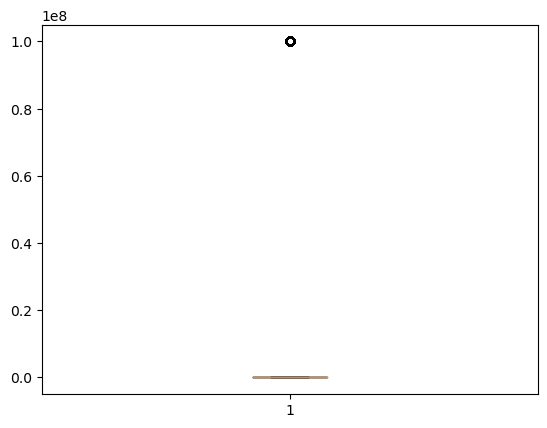

In [5]:
plt.boxplot(X_train.Current_Loan_Amount)

# Outliers of value 999999

count    31222.000000
mean        34.899846
std         21.942100
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months_since_last_delinquent, dtype: float64


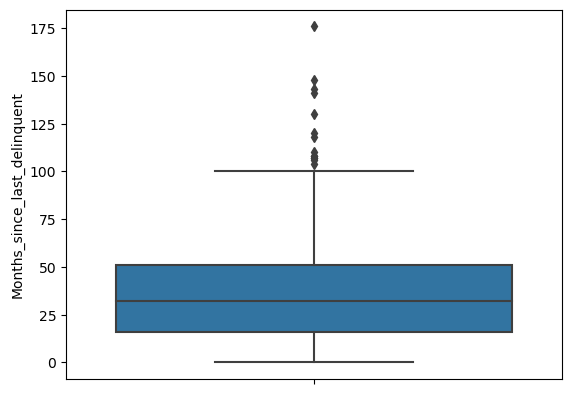

In [6]:
print(X_train.Months_since_last_delinquent.describe())
sb.boxplot(y = 'Months_since_last_delinquent' , data = X_train )
plt.show()

In [7]:
# Credit scores above 851

X_train[X_train['Credit_Score']>1000]['Credit_Score'].describe()

count    3114.000000
mean     7109.033398
std       307.957944
min      5850.000000
25%      6950.000000
50%      7180.000000
75%      7350.000000
max      7510.000000
Name: Credit_Score, dtype: float64

In [8]:
numerical_fields = ['Current_Loan_Amount'
,'Credit_Score'
,'Annual_Income'
,'Monthly_Debt'
,'Years_of_Credit_History'
,'Number_of_Open_Accounts'
,'Number_of_Credit_Problems'
,'Current_Credit_Balance'
,'Maximum_Open_Credit'
,'Bankruptcies'
,'Tax_Liens'
]
categorical_fields = ['Term', 'Home_Ownership', 'Purpose']

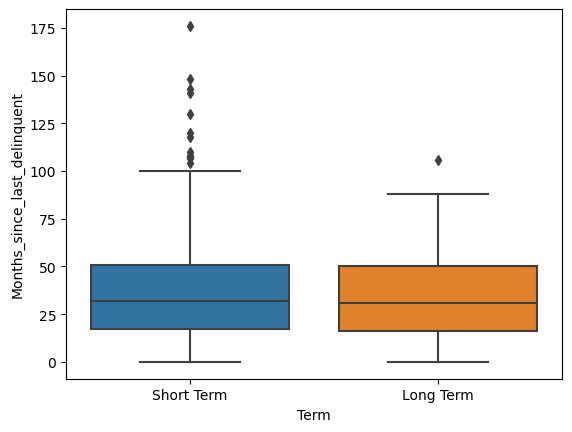

In [9]:
sb.boxplot(x = 'Term' ,y = 'Months_since_last_delinquent' , data = X_train )
plt.show()

### Chi Square Test for independence between categorical columns

In [10]:
def test_independence(df ,col1, col2, alpha=0.05):
    # Hypothesis. col1 and col2 are independent of each other.
    # We'll be using chi square test of independence for this

    #Obeserved values
    tab = pd.crosstab(index=df[col1], columns=df[col2])
    tab_Obs = tab.copy()
    tab_Obs['rowsum'] = tab_Obs.sum(axis = 1)
    tab_Obs.loc['colsum',:] = tab_Obs.sum(axis =0)
    
    #Expected values
    tab_Exp = tab_Obs.copy()
    for tab_col in tab_Exp.columns:
        for i in tab_Exp.index[:-1]:
            tab_Exp.loc[i,tab_col] = tab_Exp.loc['colsum',tab_col] * tab_Exp.loc[i,'rowsum'] / tab_Exp.loc['colsum','rowsum']  
    
    #chi square value between col1 and col2
    chi_sq = np.sum(np.sum((tab_Exp - tab_Obs)**2/(tab_Exp)))
    
    df_value = (len(df[col1].unique())-1)*(len(df[col2].unique())-1)
    
    chi_crit = stats.chi2.isf(alpha,df_value)
    
    #p-value

    p = stats.chi2.sf(chi_sq,df_value)
    
    if p >= alpha : 
        return (True, p)
    else:
        return (False, p)

In [11]:
for i in range(len(categorical_fields)):
    for j in range(i+1, len(categorical_fields)):
        col1 = categorical_fields[i]
        col2 = categorical_fields[j]
        print('\n',col1.upper(),' vs ', col2.upper(),end = '   :')
        print(test_independence(X_train, col1,col2))


 TERM  vs  HOME_OWNERSHIP   :(False, 1.2164994597117956e-194)

 TERM  vs  PURPOSE   :(False, 1.7532361882513067e-73)

 HOME_OWNERSHIP  vs  PURPOSE   :(False, 0.0)


------------ TERM ------------------
Loan_Status  Charged Off  Fully Paid
Term                                
Long Term           9264       21569
Short Term         15909       64365
 
Loan_Status  Charged Off  Fully Paid
Term                                
Long Term       0.300457    0.699543
Short Term      0.198184    0.801816


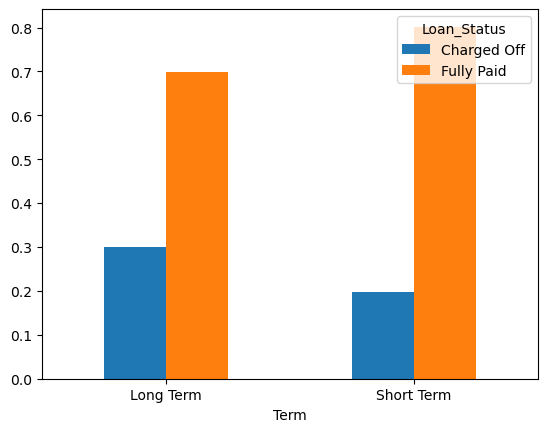

 
------------ HOME_OWNERSHIP ------------------
Loan_Status     Charged Off  Fully Paid
Home_Ownership                         
HaveMortgage             34         199
Home Mortgage         11033       42785
Own Home               2337        7851
Rent                  11769       35099
 
Loan_Status     Charged Off  Fully Paid
Home_Ownership                         
HaveMortgage       0.145923    0.854077
Home Mortgage      0.205006    0.794994
Own Home           0.229388    0.770612
Rent               0.251109    0.748891


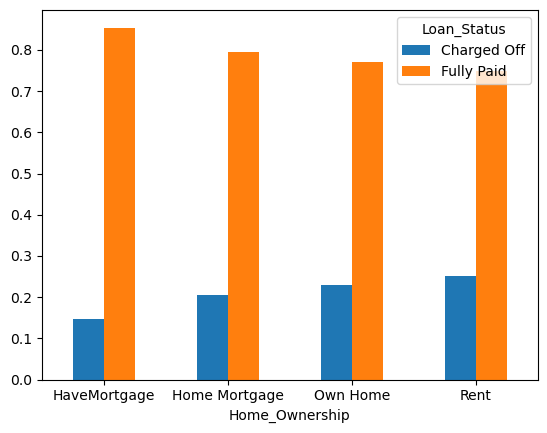

 
------------ PURPOSE ------------------
Loan_Status           Charged Off  Fully Paid
Purpose                                      
Business Loan                 533        1216
Buy House                     159         599
Buy a Car                     234        1188
Debt Consolidation          19918       67359
Educational Expenses           21          93
Home Improvements            1296        5208
Medical Bills                 311         948
Other                         667        2928
Take a Trip                   123         499
major_purchase                 99         308
moving                         49         118
other                        1572        5099
renewable_energy                4           7
small_business                131         187
vacation                       30          77
wedding                        26         100
 
Loan_Status           Charged Off  Fully Paid
Purpose                                      
Business Loan            0.304746   

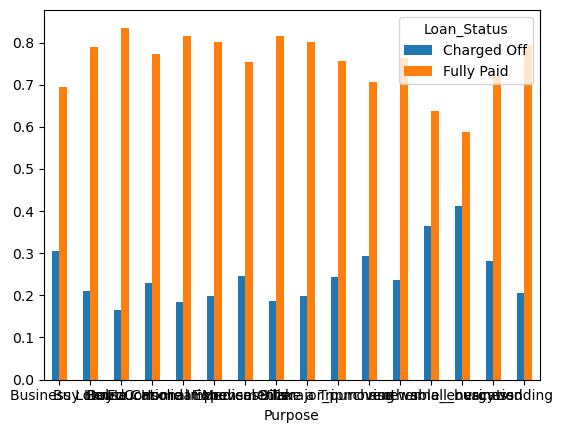

In [12]:
for cvar in categorical_fields:
    if cvar == 'Loan_Status':
        continue
    print('------------',cvar.upper(),'------------------')
    tab = pd.crosstab(df[cvar],columns=df.Loan_Status)
    print(tab)
    print(' ')
    rowtotal = tab.sum(axis =1)
    tab2 = tab.div(rowtotal,axis=0)
    print(tab2)
    tab2.plot.bar(rot=0)
    plt.show()
    print(' ')

In [13]:
# for cvar in numerical_fields:
#     sb.boxplot( x = 'Loan_Status' ,y = cvar , data = X_train )
#     plt.show()

In [14]:
# for nvar in numerical_fields:
#     plt.scatter( df.Months_since_last_delinquent, df[nvar])
#     plt.show()

## Data preparation pipeline functions

In [15]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

def data_Y_prep(y_train):
    return label_encoder.fit_transform(y_train)

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

msld_median_dict = {}

def data_prep(df_inp, y, is_test):
    
    if not is_test:
        # drop duplicates. Do not do it in test data
        df_inp['y'] = y
        df_inp.drop_duplicates(inplace=True, ignore_index = True)
        y = df_inp['y']
        df_inp.drop(['y'],inplace=True, axis =1)
        
    df_inp['Loan_Status'] = y
    
    # drop loan id, customer id and columns with null percentage > 50 %
    df_inp = df_inp.drop(['Loan_ID','Customer_ID','Months_since_last_delinquent'], axis =1)
    
    # remove the highly dependednt categorical columns
    # df_inp = df_inp.drop(['Home_Ownership','Years_in_current_job','Term'], axis =1)
    # categorical_fields = ['Purpose']
    
    #correct the data for $ sign
    for col in ['Monthly_Debt','Maximum_Open_Credit']:
        df_inp[col] = df_inp[col].astype(str)
        df_inp[col] = df_inp[col].str.replace('$', '', regex = True)
    
    # manually encode years in current job
    df_inp['Years_in_current_job'] = df_inp['Years_in_current_job'].replace({'< 1 year':0, '10+ years':10, '9 years':9, 
        '3 years':3, '2 years':2,'7 years':7, '6 years':6, '1 year':1, '5 years':5, '4 years':4, '8 years':8,np.nan:10})
    
    # merge 'other' in purpose
    df_inp['Purpose'] = df_inp['Purpose'].replace({'other':'Other'})
    
    # correct credit score for those above 1000 by dividing by 1000
    for i in df_inp[df_inp['Credit_Score']>1000].index:
        df_inp.loc[i,'Credit_Score'] = df_inp.loc[i,'Credit_Score']/10
            
    # fix the Maximum open Credit where value = '#VALUE'. 
    df_inp['Maximum_Open_Credit'] = df_inp['Maximum_Open_Credit'].replace('#VALUE!', np.nan)
    for col in ['Monthly_Debt','Maximum_Open_Credit']:
        df_inp[col] = df_inp[col].astype(float)
        
    # imputing Months_since_last_delinquent. This is specially imputed before encoding
    global msld_median_dict
    if not is_test:
        msld_median_dict = dict(df_inp.Years_in_current_job.groupby(by = df_inp.Loan_Status).median())   
    
    for i in df_inp[df_inp['Years_in_current_job'].isnull()].index.tolist():
        tlt = df_inp.loc[i,'Loan_Status']
        df_inp.loc[i,'Years_in_current_job'] = msld_median_dict[tlt]
        
    # one hot encoding for categorical variables
    df_inp = pd.get_dummies(df_inp, columns = categorical_fields)
     
#     for cvar in categorical_fields:
#         df_inp[cvar]= label_encoder.fit_transform(df_inp[cvar])
    
    test_len = len(df_inp)
    
    if is_test:
        # before imputation we need to merge it with X_train
        # X_train must be prepared before this
        frames = [X_train, df_inp]
        df_inp = pd.concat(frames, ignore_index=True)
    
    # IMPUTATION STARTS HERE
    
    # monthly debt-wise conditional mean imputation of annual income
    ai_impute_list = [df_inp[( df_inp.Monthly_Debt > df_inp.Monthly_Debt.quantile(x)) & 
       (df_inp.Monthly_Debt <= df_inp.Monthly_Debt.quantile(x+.1))].Annual_Income.mean() for x in np.linspace(0,.9,10)]

    md_list = [df_inp.Monthly_Debt.quantile(x) for x in np.linspace(0,.9,10)]

    for i in df_inp[df_inp['Annual_Income'].isnull()].index.tolist():
        for j in range(len(md_list)):
            if df_inp.loc[i,'Monthly_Debt'] >= md_list[j]:
                df_inp.loc[i,'Annual_Income'] = ai_impute_list[j] 
                
    # fixing the outliers in Current_Loan_Amount
    cla_impute_list = [df_inp[( df_inp.Monthly_Debt > df_inp.Monthly_Debt.quantile(x)) & 
           (df_inp.Monthly_Debt <= df_inp.Monthly_Debt.quantile(x+.1))].Current_Loan_Amount.median() for x in np.linspace(0,.9,10)]
    md_list = [df_inp.Monthly_Debt.quantile(x) for x in np.linspace(0,.9,10)]
    
    for i in df_inp[df_inp['Current_Loan_Amount'] == 99999999].index.tolist():
        for j in range(len(md_list)):
            if df_inp.loc[i,'Monthly_Debt'] >= md_list[j]:
                df_inp.loc[i,'Current_Loan_Amount'] = cla_impute_list[j]    
                
    # mode imputation for columns Maximum_Open_Credit, Bankruptcies and Tax_Liens
    moc_mode = int(df_inp['Maximum_Open_Credit'].mode())
    bkr_mode = int(df_inp['Bankruptcies'].mode())
    tl_mode  = int(df_inp['Tax_Liens'].mode())
    
    df_inp['Maximum_Open_Credit'].fillna(moc_mode, inplace=True)
    df_inp['Bankruptcies'].fillna(bkr_mode, inplace=True)
    df_inp['Tax_Liens'].fillna(tl_mode, inplace=True)    
    
    # mice imputation for credit score
    mice_imputer = IterativeImputer(estimator=BayesianRidge())
    df_inp = pd.DataFrame(mice_imputer.fit_transform(df_inp), columns=df_inp.columns)
    
    # droping high multi collinear columns
    df_inp = df_inp.drop(['Number_of_Credit_Problems','Loan_Status'], axis =1)
    
    curr_len = len(df_inp)
    
    if is_test:
        df_inp = df_inp.loc[curr_len - test_len:,:]
        
    return df_inp, y

In [17]:
# train data preparation
y_train = data_Y_prep(y_train)
X_train, y_train = data_prep(X_train, y_train, False)

In [18]:
print(msld_median_dict)

{0: 7.0, 1: 6.0}


In [19]:
# categorical_fields = ['Purpose']

numerical_fields = ['Current_Loan_Amount'
    ,'Credit_Score'
    ,'Annual_Income'
    ,'Monthly_Debt'
    ,'Years_of_Credit_History'
    ,'Number_of_Open_Accounts'
    ,'Current_Credit_Balance'
    ,'Maximum_Open_Credit'
    ,'Bankruptcies'
    ,'Tax_Liens' ]

### correlation coefficients

In [20]:
for i in range(len(numerical_fields)):
    for j in range(i+1, len(numerical_fields)):
        col1 = numerical_fields[i]
        col2 = numerical_fields[j]
        if np.corrcoef(X_train[col1],X_train[col2])[0][1] > .1:
            print('\n',col1.upper(),' vs ', col2.upper(),end = '   :')
            print(np.corrcoef(X_train[col1],X_train[col2])[0][1] )


 CURRENT_LOAN_AMOUNT  vs  ANNUAL_INCOME   :0.42066180577302226

 CURRENT_LOAN_AMOUNT  vs  MONTHLY_DEBT   :0.4659318164100966

 CURRENT_LOAN_AMOUNT  vs  YEARS_OF_CREDIT_HISTORY   :0.1557412627256557

 CURRENT_LOAN_AMOUNT  vs  NUMBER_OF_OPEN_ACCOUNTS   :0.21811824665555463

 CURRENT_LOAN_AMOUNT  vs  CURRENT_CREDIT_BALANCE   :0.3258027367301161

 ANNUAL_INCOME  vs  MONTHLY_DEBT   :0.6024533145870448

 ANNUAL_INCOME  vs  YEARS_OF_CREDIT_HISTORY   :0.18770590254866118

 ANNUAL_INCOME  vs  NUMBER_OF_OPEN_ACCOUNTS   :0.1948787004848849

 ANNUAL_INCOME  vs  CURRENT_CREDIT_BALANCE   :0.37365664346632677

 MONTHLY_DEBT  vs  YEARS_OF_CREDIT_HISTORY   :0.19544495717651386

 MONTHLY_DEBT  vs  NUMBER_OF_OPEN_ACCOUNTS   :0.41186566885342124

 MONTHLY_DEBT  vs  CURRENT_CREDIT_BALANCE   :0.4812393486729586

 YEARS_OF_CREDIT_HISTORY  vs  NUMBER_OF_OPEN_ACCOUNTS   :0.13703565642638926

 YEARS_OF_CREDIT_HISTORY  vs  CURRENT_CREDIT_BALANCE   :0.1992770150184409

 NUMBER_OF_OPEN_ACCOUNTS  vs  CURRENT_CREDI

## Base Model

In [21]:
y_valid = data_Y_prep(y_valid)
X_valid , y_valid = data_prep(X_valid, y_valid, True)

In [22]:
from sklearn.tree import DecisionTreeClassifier
#metrics
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

## Decision tree pruning

In [23]:
# # pruned decision tree
# # hyperparameter tuning for optimal ccp_alpha (cost complexity parameter)

# reg_tree = DecisionTreeClassifier(random_state=0)
# reg_tree.fit(X_train,y_train)
# y_pred = reg_tree.predict(X_valid)

# path = reg_tree.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas, impurities = path.ccp_alphas, path.impurities

# print('ccp_alphas:',ccp_alphas)

# # For each alpha we will append our model to a list
# clfs = []
# #ccp_alphas = np.linspace(.1,2,20)
# ccp_alphas = ccp_alphas[:-1]

# print(len(ccp_alphas))

# ccp_alphas_new = []

# for i in range(0,len(ccp_alphas),50):
#     ccp_alpha = ccp_alphas[i]
#     ccp_alphas_new.append(ccp_alpha)
#     clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
#     clf.fit(X_train, y_train)
#     clfs.append(clf)

# ccp_alphas = ccp_alphas_new
# train_acc = []
# test_acc = []
# for c in clfs:
#     y_train_pred = c.predict(X_train)
#     y_valid_pred = c.predict(X_valid)
#     train_acc.append(f1_score(y_train_pred,y_train))
#     test_acc.append(f1_score(y_valid_pred,y_valid))

# plt.scatter(ccp_alphas,train_acc)
# plt.scatter(ccp_alphas,test_acc)
# plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
# plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
# plt.legend()
# plt.title('Accuracy vs ccp_alpha')
# plt.show()

## Scaling

In [24]:
scaler = MinMaxScaler()
df_column_names = X_train.columns
robust_df = scaler.fit_transform(X_train)
X_train_scale = pd.DataFrame(robust_df, columns =df_column_names)

robust_df = scaler.fit_transform(X_valid)
X_valid_scale = pd.DataFrame(robust_df, columns =df_column_names)

### Handling data imbalance

In [25]:
from imblearn.over_sampling import SMOTE, SMOTEN, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE
    
# sm = SMOTE(random_state = 2)
# X_train_sm, y_train_sm = sm.fit_resample(X_train_scale, y_train)
# X_valid_sm = X_valid_scale

# apply near miss
from imblearn.under_sampling import NearMiss
nr = NearMiss()
X_train_sm, y_train_sm = nr.fit_resample(X_train, y_train)
X_valid_sm = X_valid

## Models

In [26]:
def transform_input(dfinp):
    dfinpcopy = dfinp.copy()
    #dfinpcopy['Current_Loan_Amount'] = np.log10(dfinp['Current_Loan_Amount'])
    #dfinpcopy['Annual_Income'] = np.square(dfinp['Annual_Income'])
    return dfinpcopy

0.590332735459894 0.8168850072780204 0.8137579026738588 0.7139771397713978 0.8153184565318456

f1_score        :  0.8153184565318456
recall_score    :  0.8168850072780204
precision_score :  0.8137579026738588
accuracy_score  :  0.7139771397713978


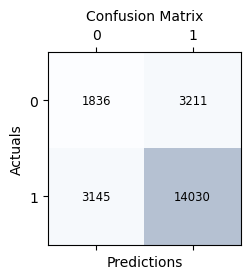

In [27]:
# X_train_sm1 = transform_input(X_train)
# X_valid_sm1 = transform_input(X_valid)

# base model
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

y_pred = model_tree.predict(X_valid)

print(roc_auc_score(y_valid, y_pred),
     recall_score(y_valid, y_pred),
     precision_score(y_valid, y_pred),
     accuracy_score(y_valid, y_pred),
     f1_score(y_valid, y_pred))

print('\nf1_score        : ',f1_score(y_valid, y_pred))
print('recall_score    : ',recall_score(y_valid, y_pred))
print('precision_score : ',precision_score(y_valid, y_pred))
print('accuracy_score  : ',accuracy_score(y_valid, y_pred))

# printing confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()

### Hyper parameter tuning with gridsearchcv

In [28]:
# from sklearn.model_selection import GridSearchCV

# param_test1 = {'max_depth':range(1,44,2),'max_leaf_nodes':range(2,14000,500)}

# gsearch1 = GridSearchCV(estimator = DecisionTreeClassifier(), 
#                                       param_grid = param_test1, scoring='f1',
#                                       n_jobs=4, cv=5)

# gsearch1.fit(X_train,y_train)

# # pd.DataFrame({'n_estimator': gsearch1.cv_results_['params'], 
# #               'mean_test_score':gsearch1.cv_results_['mean_test_score']})

# gsearch1.best_params_, gsearch1.best_score_

#### tuning results: max_depth=41,max_leaf_nodes=502

In [29]:
X_train.Credit_Score.describe()

count    64575.000000
mean       717.143375
std         26.223070
min        585.000000
25%        704.000000
50%        723.132951
75%        736.000000
max        762.734446
Name: Credit_Score, dtype: float64

## Model 2

In [30]:
from sklearn.naive_bayes import GaussianNB

In [31]:
model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

y_pred = model.predict(X_valid)
print(roc_auc_score(y_valid, y_pred),
     recall_score(y_valid, y_pred),
     precision_score(y_valid, y_pred),
     accuracy_score(y_valid, y_pred),
     f1_score(y_valid, y_pred))

0.5562027624463954 0.3515574963609898 0.8334023464458247 0.44451444514445143 0.49451269451269453


## Model 3

In [32]:
from sklearn.ensemble import RandomForestClassifier

0.5892786150793892 0.8153711790393013 0.8133348821001277 0.7126721267212672 0.8143517576250981


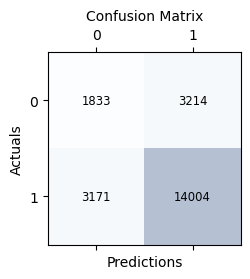

In [33]:
model_rf = DecisionTreeClassifier()
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_valid)

print(roc_auc_score(y_valid, y_pred),
     recall_score(y_valid, y_pred),
     precision_score(y_valid, y_pred),
     accuracy_score(y_valid, y_pred),
     f1_score(y_valid, y_pred))

# printing confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()

0.550971493867399 0.9525473071324599 0.7921367355832083 0.7701377013770138 0.8649677487575341

f1_score        :  0.8649677487575341
recall_score    :  0.9525473071324599
precision_score :  0.7921367355832083
accuracy_score  :  0.7701377013770138


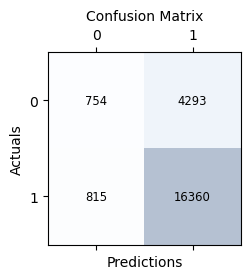

In [34]:
# final model
model_final = DecisionTreeClassifier(max_depth=41,max_leaf_nodes=502)
model_final.fit(X_train, y_train)

y_pred = model_final.predict(X_valid)

print(roc_auc_score(y_valid, y_pred),
     recall_score(y_valid, y_pred),
     precision_score(y_valid, y_pred),
     accuracy_score(y_valid, y_pred),
     f1_score(y_valid, y_pred))

print('\nf1_score        : ',f1_score(y_valid, y_pred))
print('recall_score    : ',recall_score(y_valid, y_pred))
print('precision_score : ',precision_score(y_valid, y_pred))
print('accuracy_score  : ',accuracy_score(y_valid, y_pred))

# printing confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()

### Checking other algorithms

In [35]:
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier, LogisticRegression, SGDClassifier, RidgeClassifier, RidgeClassifierCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from lazypredict.Supervised import LazyClassifier

In [48]:
# classifier_list = {NearestCentroid
# ,DecisionTreeClassifier
# ,GaussianNB 
# ,ExtraTreeClassifier
# ,Perceptron
# ,QuadraticDiscriminantAnalysis
# ,PassiveAggressiveClassifier
# ,BernoulliNB
# ,KNeighborsClassifier
# ,BaggingClassifier
# ,ExtraTreesClassifier
# ,RandomForestClassifier
# ,XGBClassifier
# ,LGBMClassifier
# ,AdaBoostClassifier
# ,LogisticRegression
# ,LinearSVC
# ,LinearDiscriminantAnalysis
# ,SGDClassifier
# ,RidgeClassifier
# ,RidgeClassifierCV
# ,DummyClassifier }

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric = roc_auc_score, classifiers = classifier_list)
# models,predictions = clf.fit(X_train, X_valid, y_train, y_valid)

# print(models)

## Final test run

In [37]:
# X_train_sm1 = transform_input(X_train)
# X_valid_sm1 = transform_input(X_valid)

y_test = data_Y_prep(y_test)
X_test , y_test = data_prep(X_test , y_test, True)

0.5859240965899537 0.8118886380737397 0.815902745463006 0.7113221132211323 0.8138907424062201

f1_score        :  0.8138907424062201
recall_score    :  0.8118886380737397
precision_score :  0.815902745463006
accuracy_score  :  0.7113221132211323


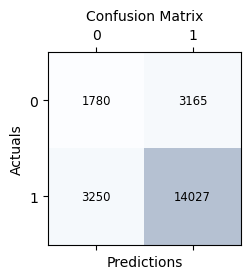

In [38]:
y_pred = model_tree.predict(X_test)

print(roc_auc_score(y_test, y_pred),
     recall_score(y_test, y_pred),
     precision_score(y_test, y_pred),
     accuracy_score(y_test, y_pred),
     f1_score(y_test, y_pred))

print('\nf1_score        : ',f1_score(y_test, y_pred))
print('recall_score    : ',recall_score(y_test, y_pred))
print('precision_score : ',precision_score(y_test, y_pred))
print('accuracy_score  : ',accuracy_score(y_test, y_pred))

# printing confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()

0.5508444835073872 0.9502228396133588 0.7964391403483239 0.7724777247772477 0.8665610979150171

f1_score        :  0.8665610979150171
recall_score    :  0.9502228396133588
precision_score :  0.7964391403483239
accuracy_score  :  0.7724777247772477


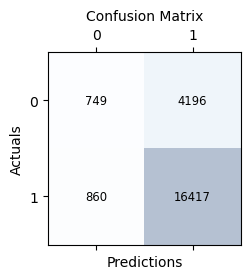

In [39]:
y_pred = model_final.predict(X_test)

print(roc_auc_score(y_test, y_pred),
     recall_score(y_test, y_pred),
     precision_score(y_test, y_pred),
     accuracy_score(y_test, y_pred),
     f1_score(y_test, y_pred))

print('\nf1_score        : ',f1_score(y_test, y_pred))
print('recall_score    : ',recall_score(y_test, y_pred))
print('precision_score : ',precision_score(y_test, y_pred))
print('accuracy_score  : ',accuracy_score(y_test, y_pred))

# printing confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()

In [40]:
df1 = pd.read_csv('Loans - Public Test Set (No Labels).csv')
df2 = pd.read_csv('Loans - Public Test Set (IDs and Labels).csv')

final_df = pd.merge(df1,df2, on = 'Loan ID', how = 'inner')
# change column names
new_column_names = [x.replace(' ','_') for x in final_df.columns]
final_df.columns = new_column_names
final_df.rename(columns = {'Loan_Status_y':'Loan_Status'}, inplace = True)

final_df["Monthly_Debt"] = final_df["Monthly_Debt"].str.replace(",", "")

X_final_test = final_df.drop(['Loan_Status','Loan_Status_x'],axis=1)
y_final_test = final_df['Loan_Status']

In [41]:
df = pd.read_csv('Loans - Training Set.csv')

# change column names
new_column_names = [x.replace(' ','_') for x in df.columns]
df.columns = new_column_names

X = df.drop('Loan_Status',axis=1)
y = df['Loan_Status']

In [42]:
# data prep final

y= data_Y_prep(y)
X , y = data_prep(X , y, False)

In [43]:
# data prep final_test

y_final_test = data_Y_prep(y_final_test)
X_final_test , y_final_test = data_prep(X_final_test , y_final_test, True)

final_testation metrics
0.5355487321160378 0.7404920296221915 0.7369078474846205 0.624443244702389 0.7386955909282997

f1_score        :  0.7386955909282997
recall_score    :  0.7404920296221915
precision_score :  0.7369078474846205
accuracy_score  :  0.624443244702389


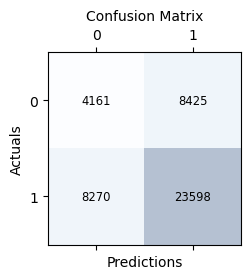

In [44]:
# final model

model_final = DecisionTreeClassifier(max_depth=31, min_samples_split=12)
model_final.fit(X_train, y_train)

print('final_testation metrics')
y_pred = model_final.predict(X_final_test)

print(roc_auc_score(y_final_test, y_pred),
     recall_score(y_final_test, y_pred),
     precision_score(y_final_test, y_pred),
     accuracy_score(y_final_test, y_pred),
     f1_score(y_final_test, y_pred))

print('\nf1_score        : ',f1_score(y_final_test, y_pred))
print('recall_score    : ',recall_score(y_final_test, y_pred))
print('precision_score : ',precision_score(y_final_test, y_pred))
print('accuracy_score  : ',accuracy_score(y_final_test, y_pred))

# printing confusion matrix
conf_matrix = confusion_matrix(y_final_test, y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()

## FINAL RESULTS

final_testation metrics

roc auc score   :  0.6679816578520674


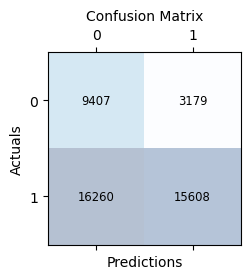

In [49]:
model_final = GaussianNB()
model_final.fit(X_train, y_train)

print('final_testation metrics')
y_pred = model_final.predict(X_final_test)
y_pred_p = model_final.predict_proba(X_final_test)

print('\nroc auc score   : ',roc_auc_score(y_final_test, pd.DataFrame(y_pred_p)[1]))
# printing confusion matrix
conf_matrix = confusion_matrix(y_final_test, y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()